In [ ]:
pip install catboost

     |████████████████████████████████| 66.1MB 57kB/s 


In [ ]:
import pandas as pd
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

#contains the probability scores for each target class obtained from Neural Network
df_train_ae = pd.read_csv('submit_proba_train.csv')
df_test_ae = pd.read_csv('submit_proba_test.csv')

df_train = pd.merge(df_train, df_train_ae, on='case_id')
df_test = pd.merge(df_test, df_test_ae, on='case_id')

In [ ]:
from tqdm import tqdm
import numpy as np

hc_un = df_train["Hospital_code"].unique()
hc_un.sort()
map_hc, map_pid = dict(), dict()
for index, val in enumerate(hc_un):
  map_hc[val] = index

for pid, df in tqdm(df_train.groupby("patientid")):
  tmp = np.zeros(len(map_hc))
  for val in df["Hospital_code"].values:
    tmp[map_hc[val]]+=1
  map_pid[pid] = tmp

# For train
tmp = list()
for val in tqdm(df_train["patientid"].values):
  tmp.append(map_pid[val])
tmp = np.array(tmp)
for i in range(len(map_hc)):
  df_train["patientid_hospital_code_"+str(i)] = tmp[:,i]

hc_un = df_test["Hospital_code"].unique()
hc_un.sort()
map_hc, map_pid = dict(), dict()
for index, val in enumerate(hc_un):
  map_hc[val] = index

for pid, df in tqdm(df_test.groupby("patientid")):
  tmp = np.zeros(len(map_hc))
  for val in df["Hospital_code"].values:
    tmp[map_hc[val]]+=1
  map_pid[pid] = tmp

# For test
tmp = list()
for val in tqdm(df_test["patientid"].values):
  tmp.append(map_pid[val])
tmp = np.array(tmp)
for i in range(len(map_hc)):
  df_test["patientid_hospital_code_"+str(i)] = tmp[:,i]

100%|██████████| 137057/137057 [00:00<00:00, 1017107.03it/s]


In [ ]:
# Bed-grade has nulls. Bed-grade is different for each hospital, and its ward type and facility
df_train["Bed Grade"] = df_train.groupby(["Hospital_code"], sort=False)["Bed Grade"].apply(lambda x: x.fillna(x.mean()))
df_test["Bed Grade"] = df_test.groupby(["Hospital_code"], sort=False)["Bed Grade"].apply(lambda x: x.fillna(x.mean()))

# City_Code_Patient has nulls. Treat them as a separate code
df_train["City_Code_Patient"] = df_train["City_Code_Patient"].fillna(39)
df_test["City_Code_Patient"] = df_test["City_Code_Patient"].fillna(39)

#Categorical and numerical columns:
cols_cat = ['Hospital_code', 'City_Code_Hospital', "Hospital_type_code", "Hospital_region_code", "Department", "Ward_Type", "Ward_Facility_Code", 'City_Code_Patient']
cols_cont = ['Available Extra Rooms in Hospital','Bed Grade', 'Visitors with Patient', 'Age', 'Admission_Deposit', "Severity of Illness", "Type of Admission"]

In [ ]:
df_train = df_train.dropna()

In [ ]:
df_train.drop(['case_id', 'patientid' ], axis=1, inplace=True)
df_test.drop(['case_id', 'patientid'  ], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train["Department"] = le.fit_transform(df_train["Department"])
df_test["Department"] = le.transform(df_test["Department"])


mp = {'P':1, 'Q':2, 'R':3, 'S':4, 'T':5, 'U':6}

df_train["Ward_Type"] = df_train["Ward_Type"].map(mp)
df_test["Ward_Type"] = df_test["Ward_Type"].map(mp)

In [ ]:
le = LabelEncoder()
mp = {'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7}

df_train["Hospital_type_code"] = df_train["Hospital_type_code"].map(mp)
df_test["Hospital_type_code"] = df_test["Hospital_type_code"].map(mp)

le = LabelEncoder()
df_train["Hospital_region_code"] = le.fit_transform(df_train["Hospital_region_code"])
df_test["Hospital_region_code"] = le.transform(df_test["Hospital_region_code"])

mp = {'A':6,'B':5,'C':4,'D':3,'E':2,'F':1}
#mp = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6}
df_train["Ward_Facility_Code"] = df_train["Ward_Facility_Code"].map(mp)
df_test["Ward_Facility_Code"] = df_test["Ward_Facility_Code"].map(mp)

In [ ]:
#df_train['Severity of Illness'].unique() 
m2 = {'Emergency':2, 'Urgent':3, 'Trauma':1}
m3 = {'Minor':1, 'Moderate':2, 'Extreme':3}

df_train['Type of Admission'] = df_train['Type of Admission'].map(m2)
df_test['Type of Admission'] = df_test['Type of Admission'].map(m2)

df_train['Severity of Illness'] = df_train['Severity of Illness'].map(m3)
df_test['Severity of Illness'] = df_test['Severity of Illness'].map(m3)

In [ ]:
m = {'0-10':0, '11-20':1, '21-30':2, '31-40':3,'41-50':4,'51-60':5,'61-70':6,'71-80':7,'81-90':8,'91-100':9,'More than 100 Days':10 }
df_train['Age'] = df_train['Age'].map(m)
df_train['Stay'] = df_train['Stay'].map(m)

df_test['Age'] = df_test['Age'].map(m)

In [ ]:
df_train = df_train.drop_duplicates(keep='first')

In [ ]:
#if hosp and patient are in same city
city = df_train['City_Code_Hospital'].values
patient = df_train['City_Code_Patient'].values
val = []

for i in range(len(city)):
  if city[i] == patient[i]:
    val.append(1)
  else:
    val.append(0)
df_train['hosp_patient_same'] = val

city = df_test['City_Code_Hospital'].values
patient = df_test['City_Code_Patient'].values
val = []

for i in range(len(city)):
  if city[i] == patient[i]:
    val.append(1)
  else:
    val.append(0)
df_test['hosp_patient_same'] = val

In [ ]:
df_train.drop(['91-100' ], axis=1, inplace=True)
df_test.drop(['91-100'  ], axis=1, inplace=True)

In [ ]:
df_train['add_age'] = df_train['Age'] * df_train['Type of Admission']
df_test['add_age'] =df_test['Age'] * df_test['Type of Admission']

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
 

X_train, Y = df_train.drop(["Stay"], axis=1).values, df_train["Stay"].values
X_test = df_test.values

In [ ]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
 
 
kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for training, testing in kfold.split(X_train):
    x_train, x_test = X_train[training], X_train[testing]
    y_train, y_test = Y[training], Y[testing]
    
    #df.columns.get_loc("pear")
    cat_feat = [df_train.columns.get_loc(i) for  i in ['Hospital_region_code','Hospital_code', 'City_Code_Hospital','Hospital_type_code','Department','City_Code_Patient', 'Gender']]
    model = LGBMClassifier(max_depth=9,random_state=22,categorical_feature=cat_feat)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    score = accuracy_score(y_test, preds)
    scores.append(score)
    print(score)
print("Average: ", sum(scores)/len(scores))

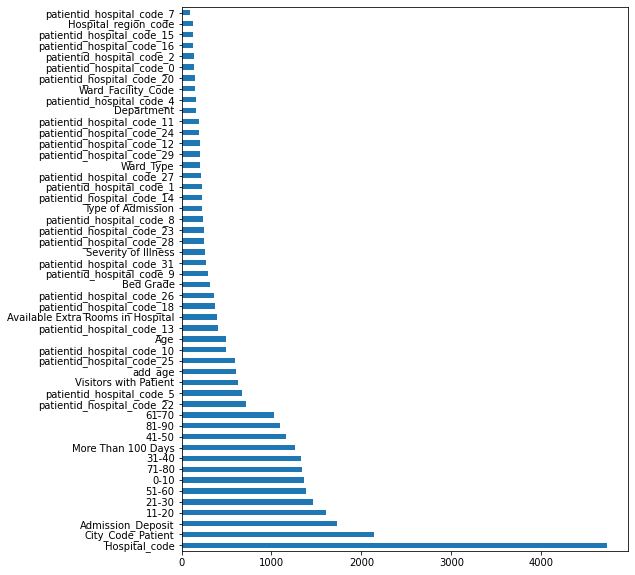

In [ ]:
#think about ward_score
feat_imp = pd.Series(model.feature_importances_, index=df_train.drop(["Stay"], axis=1).columns)
feat_imp.nlargest(50).plot(kind='barh', figsize=(8,10))

In [ ]:
#oof predictions
import numpy as np

i=0
setused=X_train
targ=Y

scores=[]
splits=5

cnf_matrix=[]
sc = 0
kfold, scores = KFold(n_splits=splits,random_state=True), list()
for train2, test2 in kfold.split(setused,targ):
    x_train, x_test = setused[train2], setused[test2]
    y_train, y_test = targ[train2], targ[test2]
    eval_set = [(x_test,y_test)]
    cat_feat = [df_train.columns.get_loc(i) for  i in ['Hospital_region_code','Hospital_code', 'City_Code_Hospital','Hospital_type_code','Department','City_Code_Patient']]
    model = LGBMClassifier(random_state=22,categorical_feature=cat_feat)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    score = accuracy_score(y_test, preds)
    scores.append(score)
    print(score)    
    sc += 1
    if i == 0:
      oof_preds = model.predict_proba(X_test)
      i += 1
    else:
      oof_preds += model.predict_proba(X_test)
oof_preds = oof_preds/sc

print("Average: ", np.sum(scores)/len(scores))

In [ ]:
final_preds = np.argmax(oof_preds, axis = 1)

In [ ]:
m_rev = {'0':'0-10', '1':'11-20', '2':'21-30', '3':'31-40','4':'41-50','5':'51-60','6':'61-70','7':'71-80','8':'81-90','9':'91-100','10':'More than 100 Days' }
new_preds= []
for i in range(len(final_preds)):
  new_preds.append(m_rev[str(int(final_preds[i]))])


In [ ]:
df_submit = pd.DataFrame({'Stay': new_preds})
df_submit.to_excel("submit.xlsx", index=False)